In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

<span style="color: red;">
<div dir='rtl'>

<b> نام و نام‌‌خانوادگی: سید احسان حسن بیگی</b>

<b> شماره دانشجویی: ۴۰۲۲۱۱۷۲۳</b>

</span>

<div dir='rtl'>
<h1> 
مقدمه
</h1>
<p>
در این تمرین قصد داریم به مباحث زیر بپردازیم:
<li> کاهش ابعاد </li>
<li> خوشه‌بندی متن و هرس‌کردن خوشه‌ها</li>

کتابخانه‌های مورد نظرتان را هم می‌توانید در اولین سل نوت‌بوک فراخوانی کنید. 

تمرین درباره ی خوشه بندی اهنگ های مشابه در اپ اسپاتیفای است که از دیتاستی از سایت کگل برداشته شده است.
</p>
</div>

<div dir="rtl">
<h1>
لود دیتا</h1>
</div>

<div dir="rtl">
در این بخش باید دیتا را لود کرده و در انتها فقط نام آهنگ و فیچر هایی که به نظرتان مفید است را با ذکر علتی کوتاه نگه دارید. 
</div>

In [2]:
raw_data = pd.read_csv("datasets/spotify.csv")
raw_data = raw_data.dropna()

# merge rows with the same 'track_id'
# replace numeric columns with the mean
# replace non-numeric columns with the most frequent value
# numeric_columns = raw_data.select_dtypes(include=["number"]).columns.tolist()
# non_numeric_columns = raw_data.select_dtypes(exclude=["number"]).columns.tolist()
# raw_data = raw_data.groupby("track_id", as_index=False).agg(
#     {
#         **{col: "mean" for col in numeric_columns},
#         **{col: lambda x: x.mode().iloc[0] for col in non_numeric_columns},
#     }
# )

In [3]:
garbage_cols = ["track_id", "track_album_id", "playlist_id", "playlist_name", "track_album_release_date",
                "track_name", "track_album_name", "playlist_subgenre", "track_artist"]

le_data = raw_data.copy().drop(columns=garbage_cols, axis=1)
non_numeric_columns = le_data.select_dtypes(exclude=["number"]).columns.tolist()
# label_encoder_dict = {}
for col in non_numeric_columns:
    le = preprocessing.LabelEncoder()
    le_data[col] = le.fit_transform(le_data[col])
    # if col == 'track_name':
    #     track_name_le = le
    # label_encoder_dict[col] = le


<div dir="rtl">
توضیح دهید که دیتای scale نشده چه مشکلی میتواند برای خوشه بندی ایجاد کند?
<br>
در این cell باید یک standard scalar را از صفر پیاده سازی نمایید. تا برای قسمت های بعدی یک دیتای مناسب داشته باشید.
</div>

In [4]:
# standardization
def standardize(df, numeric_columns=None):
    if numeric_columns is None:
        numeric_columns = df.select_dtypes(include=["number"]).columns.tolist()

    column_stats = {}
    for col in numeric_columns:
        mean = df[numeric_columns][col].mean()
        std = df[numeric_columns][col].std()
        column_stats[col] = {'mean': mean, 'std': std}

        df[col] = (df[col] - mean) / std

    return df, column_stats

<div dir="rtl">
<h1>
کاهش ابعاد
</h1>
</div>

<div dir="rtl">
یکی از روش‌های کاهش ابعاد، PCA است. با استفاده از پیاده‌سازی آن در کتابخانه sklearn، ابعاد ویژگی‌ را کاهش دهید.
<br>
سپس با استفاده از explained_variance_ratio_ در الگوریتم PCA  نشان دهید که با وجود یک ترشولد مناسب  تا چه میزان میتوان ابعاد ویژگی ها را کم تر کرد.
<br>
برای ترشولدی که انتخاب کردید دلیل بیاورید و شهود این متغیر را توضیح دهید.
</div>

In [5]:
def reduce_dimension(embedding, n_components=None):
    """
    Performs dimensional reduction using PCA with n components left behind

    Parameters
    ----------
    embeddings : List
        A list of embeddings of documents

    n_components: int
        Number of components to keep

    Returns a list of reduced embeddings
    """
    pca = PCA(n_components)
    pca.fit(embedding)
    explained_variance_ratio = pca.explained_variance_ratio_
    print(
        f"Explained Variance Ratio for Each PC: {explained_variance_ratio} \nwith len= {len(explained_variance_ratio)}"
    )
    return pca.transform(embedding)

In [6]:

normalized_data, _ = standardize(le_data)
latent_data = reduce_dimension(normalized_data, .95)
print(latent_data.shape)

Explained Variance Ratio for Each PC: [0.15906811 0.11447319 0.0940364  0.08505356 0.08280165 0.07398989
 0.06981214 0.06110382 0.05780611 0.05767164 0.05251026 0.04401846] 
with len= 12
(32828, 12)


In [7]:
# TODO: Findout the most reduced dimension which has a high cutoff explained variance. Write down the value of cut off and explain it.

<div dir="rtl">
<h2>
خوشه‌بندی
</h2>
</div>

<div dir="rtl">
در این قسمت، شما ابتدا الگوریتم خوشه‌بندی K-means را 
<u><b>از پایه</b></u>
 پیاده‌سازی می‌کنید.

</div>

In [8]:
class KMeans:
    def __init__(self, n_clusters, max_steps=100, random_state=None):
        self.n_clusters = n_clusters
        self.max_steps = max_steps
        self.random_state = random_state
        self.centroids = None
        self.cluster_indices = None

    def fit(self, X):
        np.random.seed(self.random_state)

        # randomly initialize centroids
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_steps):
            self.cluster_indices = self.__get_new_clusters(X)
            new_centroids = self.__get_new_centroids(X)
            
            # check for convergence
            if np.all(new_centroids == self.centroids):
                break

            self.centroids = new_centroids

        return self.centroids, self.cluster_indices

    def __get_new_clusters(self, X):
        # adding new axis to calculate distances of each data point w.r.t all centroids
        distances = np.linalg.norm(X[:, np.newaxis, :] - self.centroids, axis=2)
        return np.argmin(distances, axis=1)

    def __get_new_centroids(self, X):
        new_centroids = np.array(
            [X[self.cluster_indices == k].mean(axis=0) for k in range(self.n_clusters)]
        )
        return new_centroids
    
    def calc_wss(self, X):
        # Calculate the Within Cluster Sum of Squares (WSS)
        wss = 0
        for i in range(len(self.centroids)):
            cluster_points = X[self.cluster_indices == i]
            wss += np.sum((cluster_points - self.centroids[i])**2)
        return wss
    
    # this method only works for 2D feature spaces
    # call this after the fit method
    def visualize(self):
        for k in range(self.n_clusters):
            cluster_points = latent_data[self.cluster_indices == k]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {k + 1}')

        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c='red', marker='X', label='Centroids')

        plt.title('K-Means Clustering')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.show()


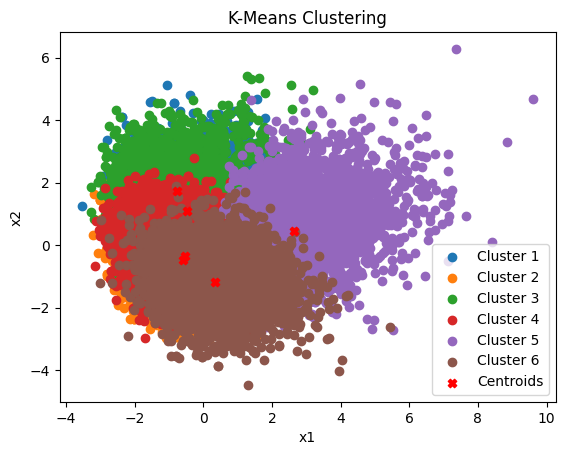

In [9]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
final_centroids, final_cluster_indices = kmeans.fit(latent_data)

# print("final cluster indices:", final_cluster_indices)
# print("final centroids:", final_centroids)
kmeans.visualize()

<div dir="rtl">
 با استفاده از K-Means خوشه‌ها را ایجاد کنید. الگوریتم را با استفاده از چند مقدار مختلف تعداد خوشه‌ها (k) اجرا کنید. در هربار اجرا، با استفاده از تعدادی از اسناد موجود در هر خوشه، موضوع آن خوشه را تعیین کرده و خوشه‌بندی حاصله را با استفاده از بردار‌های دوبعدی قسمت قبل، رسم کنید. با اینکار، پیاده‌سازی خود و همچنین کارایی این الگوریتم در خوشه‌بندی اسناد و قرار دادن اسناد مشابه در خوشه‌های یکسان را بررسی کنید.
<br>

 نمودار silhouette score برای مقدار‌های مختلف k را رسم کرده و silhouette analysis برای انتخاب k مناسب انجام دهید. 
<br>
همچنین Within-Cluster Sum of Squares (WSS) را نیز محاسبه کرده و در نهایت این دو کار بهترین مقدار k  را بدست بیاورید.
</div>

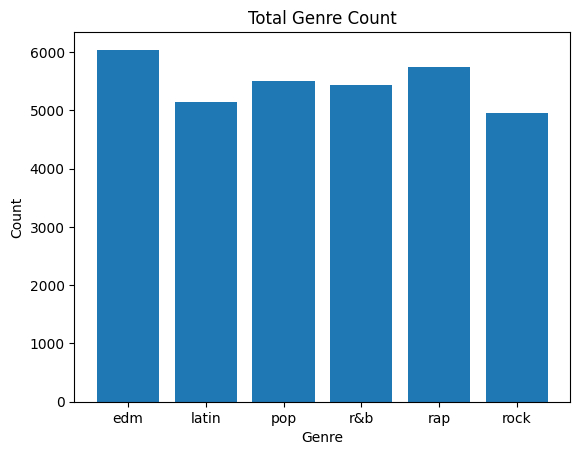

---------------


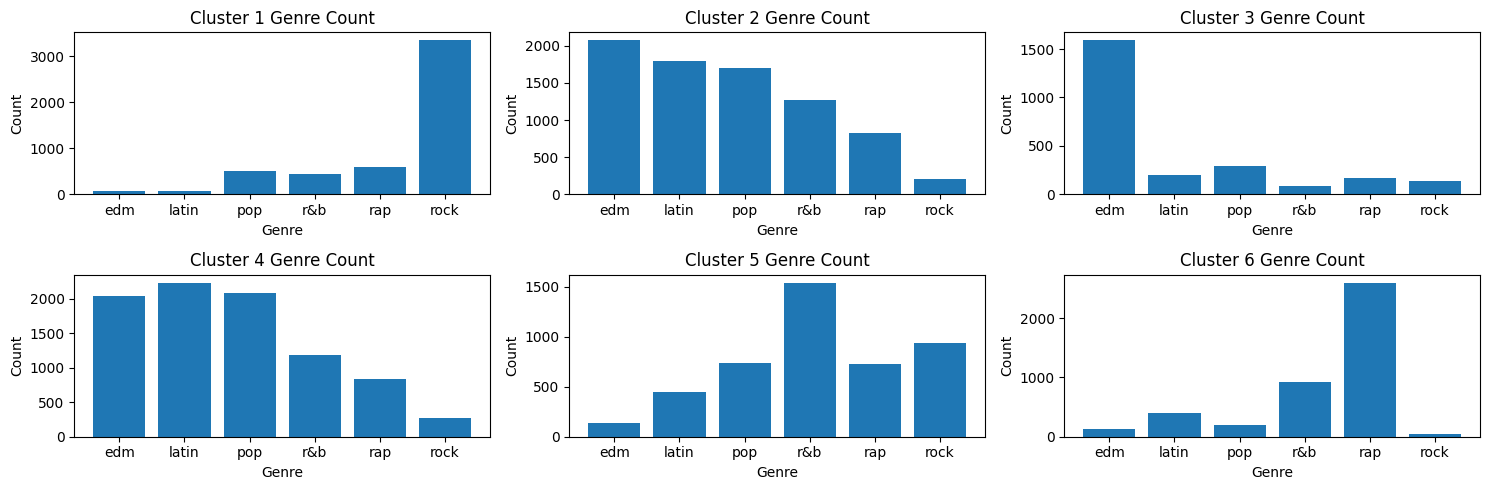

In [10]:
total_genre_count = raw_data.groupby("playlist_genre").size().reset_index(name="count")
plt.bar(total_genre_count["playlist_genre"], total_genre_count["count"])
plt.xlabel("Genre")
plt.ylabel("Count")
plt.title("Total Genre Count")
plt.show()
print("---------------")

fig, axes = plt.subplots(nrows=int(np.ceil(n_clusters / 3)), ncols=3, figsize=(15, 5))
cluster_genre_count = []
for i in range(n_clusters):
    cluster_genre_count.append(
        raw_data[final_cluster_indices == i]
        .groupby("playlist_genre")
        .size()
        .reset_index(name="count")
    )
    axes_row = int(np.floor(i / 3))
    axes_col = i % 3
    axes[axes_row][axes_col].bar(
        cluster_genre_count[i]["playlist_genre"], cluster_genre_count[i]["count"]
    )
    axes[axes_row][axes_col].set_xlabel("Genre")
    axes[axes_row][axes_col].set_ylabel("Count")
    axes[axes_row][axes_col].set_title(f"Cluster {i+1} Genre Count")

plt.tight_layout()
plt.show()

calculating scores for cluster count = 2
calculating scores for cluster count = 3
calculating scores for cluster count = 4
calculating scores for cluster count = 5
calculating scores for cluster count = 6
calculating scores for cluster count = 7
calculating scores for cluster count = 8
calculating scores for cluster count = 9
calculating scores for cluster count = 10
calculating scores for cluster count = 11
calculating scores for cluster count = 12
calculating scores for cluster count = 13
calculating scores for cluster count = 14
calculating scores for cluster count = 15
calculating scores for cluster count = 16
calculating scores for cluster count = 17
calculating scores for cluster count = 18
calculating scores for cluster count = 19
calculating scores for cluster count = 20


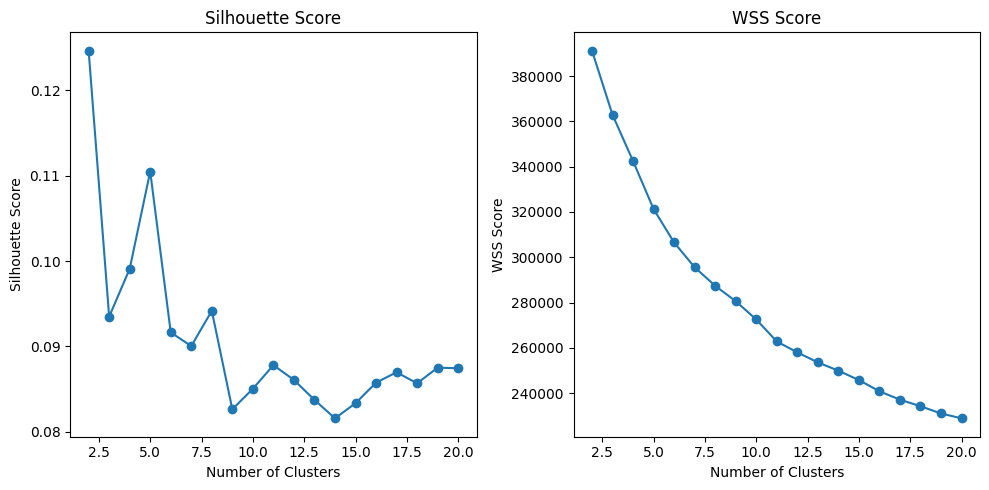

In [11]:
def calc_cluster_scores(cluster_range, X):
    silhouette_scores, wss_scores = [], []
    for n_clusters in cluster_range:
        print(f"calculating scores for cluster count = {n_clusters}")
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        _, final_cluster_indices = kmeans.fit(X)

        silhouette_avg = silhouette_score(X, final_cluster_indices)
        silhouette_scores.append(silhouette_avg)
        wss_scores.append(kmeans.calc_wss(X))

    return silhouette_scores, wss_scores


max_cluster_count = 20
cluster_range = range(2, max_cluster_count + 1)
silhouette_scores, wss_scores = calc_cluster_scores(cluster_range, latent_data)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].plot(cluster_range, silhouette_scores, marker="o")
# axes[0].set_xticks
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Score")

axes[1].plot(cluster_range, wss_scores, marker="o")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("WSS Score")
axes[1].set_title("WSS Score")

plt.tight_layout()
plt.show()

In [12]:

def wss_score():
    #TODO
    pass

def silhouette_score():
    #TODO
    pass

In [13]:
# TODO: Calculate silhouette score and wss score

In [14]:
# TODO: Plot silhouette score for different value of k 

In [15]:
#TODO: plot wss for different value of k 

<div dir="rtl">
با استفاده از نمودارهای رسم شده توضیح دهید بهترین k برای انتخاب در داده ما با استفاده از الگوریتم K-Means چیست؟
چرا؟
</div>

<span style="color: red;">#TODO: Write your answer in here.</span>

<div dir="rtl">
<h2>
بررسی خروجی</h2>
</div>

<div dir="rtl">
در این قسمت برای اینکه ببینیم چقدر خوب خوشه بندی را انجام داده ایم, از یک روش sample check و نیز TSNE استفاده خواهیم کرد.

</div>

<div dir="rtl">
در ابتدا به صورت رندوم از هر خوشه دو اهنگ را انتخاب کرده (با توجه به اینکه در بخش اول بایستی اسم اهنگ را نیز نگه میداشتید) و ببینید واقعا این اهنگ ها به هم نزدیک هستند یا خیر.
نکته اینکه صرفا بررسی این عمل نمره دارد و نیازی به خیلی دقیق بودن خروجی نیست.
</div>

In [16]:
# TODO: Sample 2 songs from each cluster and compare them.

<div dir="rtl">
با استفاده از این T-SNE و کاهش ابعاد به 2 بعد نشان دهید که ایا خوشه بنده به خوبی انجام شده است یا خیر.

</br>
در صورت پیاده سازی تابع tsne  از ابتدا, نمره ی امتیازی به شما تعلق خواهد گرفت.
</div>

In [17]:
# TODO: Visualize the clusters 

In [18]:
# Bonus TODO: Implement TSNE from scratch